In [1]:
%load_ext autoreload
%autoreload 2
import glob
import json
import numpy as np
import pandas as pd
import import_lakes

In [2]:
df = import_lakes.import_lake(r'./data/lakegreifenctdprofiles_datalakesdownload/*.json')

In [34]:
import matplotlib.pyplot as plt

In [242]:
df['x'].values[0] / 60 /60 - df['x'].values[8] / 60 /60

-23.608888888848014

# chunk data into days

In [302]:
day_df = pd.DataFrame([df.to_numpy()[i*8:(i+1)*8].mean(axis=0) for i in range(len(df)//8)],columns=df.columns)

In [304]:
day_df

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.593633e+09,9.914375,0.368563,0.250000,70.923749,7.37500,7.953188,14.26250,-0.25000,3.46875,-0.36875
1,1.593719e+09,10.816688,0.376937,0.249563,90.485001,9.22500,8.042875,13.77500,-0.11875,3.69375,0.29375
2,1.593805e+09,10.702438,0.376812,0.249875,79.800000,8.34375,7.987875,11.38125,-0.13750,3.77500,-1.81875
3,1.593892e+09,10.936375,0.378625,0.250000,82.480000,8.55000,8.012750,10.71875,0.00000,3.83125,-1.71250
4,1.593978e+09,10.504125,0.374938,0.249875,79.435624,8.32500,7.973062,10.49375,-0.04375,3.41250,0.51875
...,...,...,...,...,...,...,...,...,...,...,...
791,1.681658e+09,7.729063,339.412498,463.231247,102.089374,9.02500,10.119812,15.81250,1.80000,2.90000,-3.05625
792,1.681831e+09,7.400437,336.993752,463.937496,96.271875,8.71250,10.044563,12.76875,1.86250,2.25625,-3.07500
793,1.682003e+09,7.876125,342.250000,464.543743,95.108749,8.51875,10.219688,15.11875,2.23750,2.82500,-3.25000
794,1.682176e+09,7.771437,341.250000,464.724998,94.716874,8.37500,10.324188,13.72500,2.35000,2.60625,-1.57500


In [303]:
day_df['x'].values[0] / 60 /60 - day_df['x'].values[1] / 60 /60

-23.95111111109145

In [435]:
me = lambda x: np.max(x,3)

0      14.26250
1      13.77500
2      11.38125
3      10.71875
4      10.49375
         ...   
791    15.81250
792    12.76875
793    15.11875
794    13.72500
795    11.75000
Name: z6, Length: 796, dtype: float64

In [438]:
day_df['z6'] = np.maximum(day_df['z6'],3)

In [493]:
from scipy.ndimage import gaussian_filter1d

In [499]:
# Create filters to have smoother data points

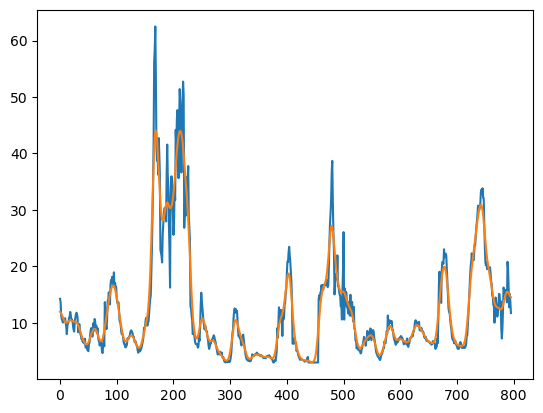

In [498]:
plt.plot(day_df['z6'].values)
plt.plot(gaussian_filter1d(day_df['z6'].values,4))

In [500]:
z6data = gaussian_filter1d(day_df['z6'].values,4)

## Create Training Data predict directly

In [531]:
chloro = z6data[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps, len(chloro)-6):
    X.append(chloro[i-n_steps:i])
    Y.append(chloro[i+6])
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

## Define LSTM model to predict algea consentration of t+1 based on concentration at t

In [532]:
from NN import LSTM_model
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 

In [533]:
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [534]:
model_1 = LSTM_model(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

In [540]:
model_1.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
for i in range(100):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_1(x.T.unsqueeze(2))
        lossfunction = nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))

34.76345772612585
33.02154372979517
32.49243688624199
32.10117069825734
31.221395070422187
29.512682203560658
29.641282348600154
28.377366890646005
27.486723467095256
27.19010688629869
26.003741412946624
25.48766940342237
25.50546629134923
24.281170099157176
23.70120329726232
23.233104688255754
22.524339132113
21.719042952848625
21.617631548888063
21.01424178440277
20.37727891133256
20.602588242455706
19.538031507028293
19.000820721257224
18.605502074711943
18.081499422249728
17.918969352359642
17.315728929353085
16.735700507482438
16.513422591433134
16.05683685900414
15.865233029404731
15.257150907936978
14.958404355261424
14.634676641389115
14.8510907284201
14.042375927102077
13.540541836660202
13.333317950572052
13.134038025385713
12.677892670239487
12.372480153016848
12.770264879889684
11.77594134905567
11.548969596624374
11.172714121537666
10.94923300775763
10.580036145775285
10.479368056336494
10.24736380822038
10.047668114916918
9.786230671385379
9.860944397237203
9.253484114188

(350.0, 400.0)

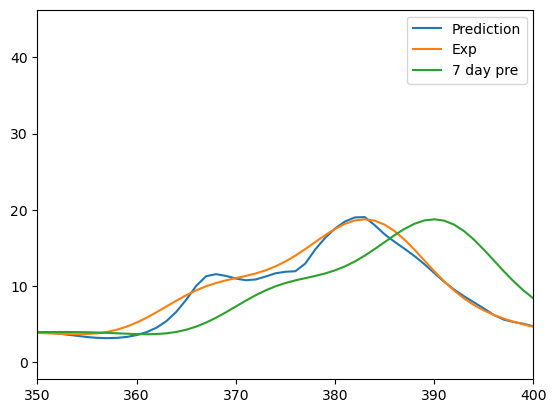

In [549]:
out, _ = model_1(X_train.T.unsqueeze(2))
plt.plot(out.tolist(),label='Prediction')
plt.plot(Y_train.tolist(),label='Exp')
plt.plot([0 for i in range(7)]+[y for y in Y_train.tolist()],label='7 day pre')
plt.legend()
plt.xlim(350,400)

In [551]:
chloro = z6data[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps, len(chloro)-6):
    X.append(chloro[i-n_steps:i])
    Y.append(chloro[i+6])
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [552]:
out, _ = model_1(X_test.T.unsqueeze(2))

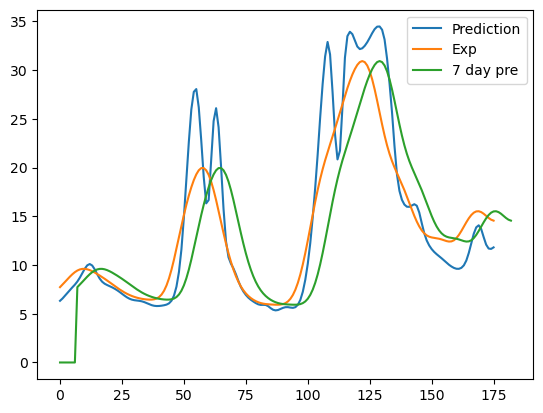

In [555]:
plt.plot(out.tolist(),label='Prediction')
plt.plot(Y_test.tolist(),label='Exp')
plt.plot([0 for i in range(7)]+[y for y in Y_test.tolist()],label='7 day pre')
plt.legend()
#plt.xlim(50,70)

# Change and study the relative change

In [388]:
[np.maximum(np.minimum((chloro[i-n_steps:i] - chloro[i-1-n_steps:i-1]) / chloro[i-1-n_steps:i-1],2),-2) for i in range(n_steps+1, len(chloro))]

[array([-0.03418054, -0.17377495, -0.05820978, -0.02099126, -0.04050029,
         0.03786467, -0.00717702,  0.00843373,  0.03643966, -0.08242075,
        -0.06532663, -0.13709678,  0.18613707,  0.04267891]),
 array([-0.17377495, -0.05820978, -0.02099126, -0.04050029,  0.03786467,
        -0.00717702,  0.00843373,  0.03643966, -0.08242075, -0.06532663,
        -0.13709678,  0.18613707,  0.04267891,  0.02078088]),
 array([-0.05820978, -0.02099126, -0.04050029,  0.03786467, -0.00717702,
         0.00843373,  0.03643966, -0.08242075, -0.06532663, -0.13709678,
         0.18613707,  0.04267891,  0.02078088,  0.08266501]),
 array([-0.02099126, -0.04050029,  0.03786467, -0.00717702,  0.00843373,
         0.03643966, -0.08242075, -0.06532663, -0.13709678,  0.18613707,
         0.04267891,  0.02078088,  0.08266501,  0.01139601]),
 array([-0.04050029,  0.03786467, -0.00717702,  0.00843373,  0.03643966,
        -0.08242075, -0.06532663, -0.13709678,  0.18613707,  0.04267891,
         0.02078088,  

In [556]:
from NN import LSTM_model_sig

In [564]:
chloro = z6data[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-6):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps:i])
    Y.append((chloro[i+6] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [565]:
model_2 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [566]:
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [567]:
model_2.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
for i in range(100):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_2(x.T.unsqueeze(2))
        lossfunction = nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))

0.23776455672636423
0.11757277993306722
0.11779287070903467
0.11329080455311358
0.10862124951122558
0.10765427560226558
0.11215482465922832
0.11585096410182241
0.1090264351119938
0.11159541567608919
0.10756106889002943
0.10643273410833862
0.10203367152748859
0.10801941572930919
0.10187318183685819
0.10278486891662421
0.10800258082988327
0.10614917554879842
0.10028413742500013
0.10059657277003543
0.09821707913524484
0.10560601801700788
0.10361983747004647
0.09648726374063998
0.09893352729714897
0.09749973477310922
0.10194802228106212
0.09940499784297323
0.09877204254575789
0.09500749151490323
0.09234571018039364
0.09675840648171836
0.0906435917195392
0.0947020232983648
0.07699103197975926
0.06269462106825963
0.0512213545073181
0.042729394835713384
0.037133444831004905
0.026923861504494124
0.020610456651535956
0.014104703654956124
0.010559908613524311
0.010392524188779907
0.008981053789197276
0.007623418733439319
0.00531937495902203
0.005688508736505492
0.006037519329342328
0.00534024289

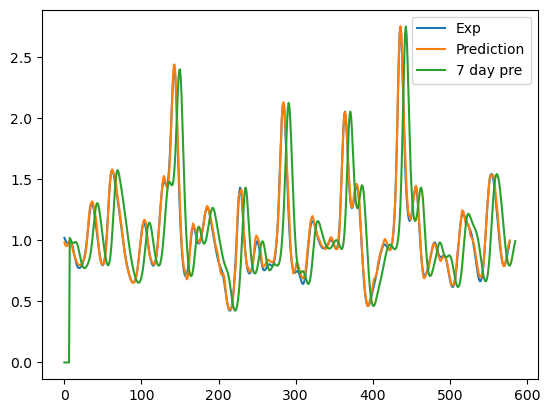

In [570]:
out, _ = model_2(X_train.T.unsqueeze(2))
plt.plot(Y_train.tolist(),label='Exp')
plt.plot(out.tolist(),label='Prediction')
plt.plot([0 for i in range(7)]+[y for y in Y_train.tolist()],label='7 day pre')
plt.legend()

In [575]:
chloro = z6data[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-6):
    X.append( chloro[i-n_steps:i])
    Y.append((chloro[i+6] / chloro[i-1] ))
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [576]:
out, _ = model_2(X_test.T.unsqueeze(2))

(-9.05, 190.05)

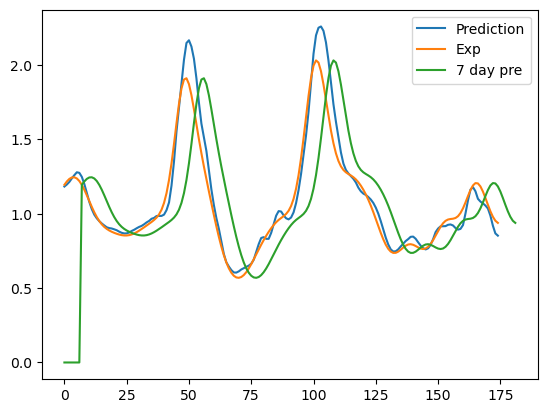

In [578]:
plt.plot(out.tolist(),label='Prediction')
plt.plot(Y_test.tolist(),label='Exp')
plt.plot([0 for i in range(7)]+[y for y in Y_test.tolist()],label='7 day pre')
plt.legend()
plt.xlim()

In [481]:
reconstruct = np.array(Y_train.tolist())

In [486]:
reconstruct[0] = 5
for i in range(1,len(reconstrunct)):
    reconstruct[i] = reconstruct[i]*reconstruct[i-1]

IndexError: index 181 is out of bounds for axis 0 with size 181

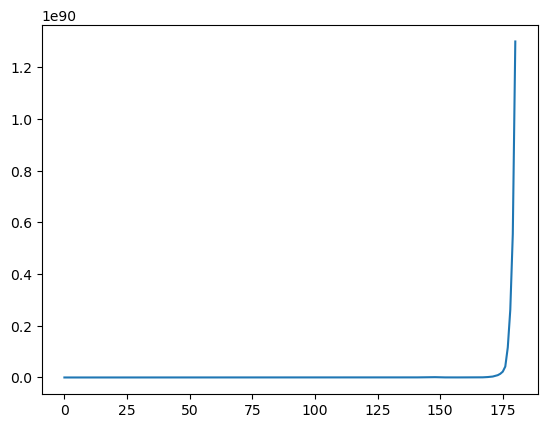

In [487]:
plt.plot(reconstruct)

In [485]:
reconstruct

array([[ 5.        ],
       [ 4.90506291],
       [ 5.10618515],
       [ 5.64375358],
       [ 5.80899768],
       [ 5.62340403],
       [ 5.52767835],
       [ 5.59002694],
       [ 5.35153341],
       [ 5.3657017 ],
       [ 5.26182776],
       [ 5.19108426],
       [ 5.45362715],
       [ 6.18129034],
       [ 6.26839468],
       [ 6.0092903 ],
       [ 5.89351669],
       [ 5.66702653],
       [ 5.47868384],
       [ 5.36753496],
       [ 5.46237054],
       [ 5.35056904],
       [ 5.33046121],
       [ 5.27071932],
       [ 5.09075879],
       [ 4.84716986],
       [ 4.76437813],
       [ 4.66872518],
       [ 4.3745823 ],
       [ 4.13228384],
       [ 3.95790528],
       [ 3.89827537],
       [ 3.73485314],
       [ 3.59549907],
       [ 3.52137021],
       [ 3.46959202],
       [ 3.36002654],
       [ 3.26390021],
       [ 3.17208322],
       [ 3.10870476],
       [ 3.06372446],
       [ 3.01624054],
       [ 2.98120715],
       [ 3.05284227],
       [ 3.19623867],
       [ 3

In [189]:
Y_train

tensor([13.1000, 12.4000, 11.8000,  ..., 14.6500, 11.2000, 12.0500],
       device='cuda:0')

In [167]:
Y_train.shape

torch.Size([6360])

In [96]:
model_1(X_train[6].unsqueeze(1).unsqueeze(1))

(tensor([[[0.1264]],
 
         [[0.1333]],
 
         [[0.1368]],
 
         [[0.1389]],
 
         [[0.1402]],
 
         [[0.1411]],
 
         [[0.1418]],
 
         [[0.1422]],
 
         [[0.1426]],
 
         [[0.1428]],
 
         [[0.1429]],
 
         [[0.1430]],
 
         [[0.1430]],
 
         [[0.1431]]], grad_fn=<ViewBackward0>),
 (tensor([[[-4.6607e-02,  2.7681e-01, -9.6340e-02, -5.5133e-01, -4.1619e-01,
             2.5147e-01,  9.7877e-02,  8.3170e-02, -1.9327e-01, -1.1149e-01,
            -1.7025e-01,  3.1178e-01, -9.8659e-02, -5.1053e-01,  1.2307e-01,
            -1.6202e-01,  2.3962e-01, -1.3118e-01,  4.9181e-01, -2.1727e-01,
             1.0505e-01,  2.7870e-02,  5.2373e-01, -2.8528e-01,  2.2369e-01,
            -1.6541e-01,  1.8334e-01, -4.6277e-01,  9.7272e-02, -3.5763e-01,
            -3.2721e-01, -2.5504e-01,  3.7436e-01,  1.0843e-01,  7.7991e-02,
             1.6143e-01, -3.9268e-01,  9.0070e-02, -8.2773e-02, -2.6265e-01,
             3.3021e-01,  1.2986e-01,

In [67]:
Y_train[0].unsqueeze(1).unsqueeze(1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [64]:
output, (hn,cn) = model_1(X_train[0].unsqueeze(1).unsqueeze(1))

In [44]:
output

tensor([[[0.0677]],

        [[0.0580]],

        [[0.0673]],

        ...,

        [[0.0881]],

        [[0.0881]],

        [[0.0881]]], grad_fn=<ViewBackward0>)

In [8]:
class model(nn.Module):

    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM()

In [4]:
from sklearn.decomposition import PCA

In [5]:
pca = PCA(n_components=2)

In [10]:
df_no8 = df[['z','z1','z2','z3','z4','z5','z6']]

In [11]:
pca.fit(df_no8)

PCA(n_components=2)

In [12]:
print(pca.explained_variance_ratio_)

[0.9439926  0.05204318]


In [13]:
pca.components_

array([[-2.61983309e-03,  6.01555234e-01,  7.96292088e-01,
         6.35652995e-02,  6.40384360e-05, -2.01413256e-04,
        -1.65993347e-03],
       [ 7.36924403e-03,  2.78751949e-02, -1.00354600e-01,
         9.94126097e-01,  2.16086432e-02,  3.82194330e-03,
         1.81489445e-02]])

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

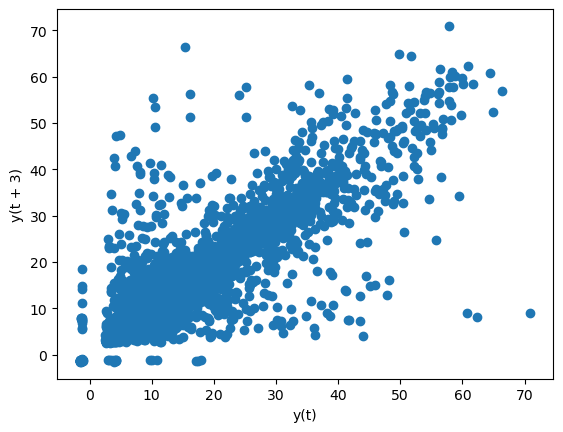

In [21]:
pd.plotting.lag_plot(df["z6"], lag=3)

In [16]:
time_step = df["x"][1] - df["x"][0]

In [19]:
print(f"Time step: {time_step} seconds")
print(f"Time step: {time_step/60/60} hours")

Time step: 10880.0 seconds
Time step: 3.0222222222222226 hours


array([[15.19999981,  7.55800009],
       [13.5       ,  8.01900005],
       [14.14999962,  8.02700043],
       ...,
       [14.64999962, 10.4659996 ],
       [11.19999981, 10.34599972],
       [12.04999924, 10.26749992]])

In [138]:
X_train.shape

torch.Size([5087, 12, 2])

In [152]:
y_train.shape

torch.Size([5087])

In [153]:
outputs.shape

torch.Size([12, 1])